# CV Quantum Circuits

In a conventional quantum circuit, qubits represented by wires are operated on by quantum gates which collectively perform computations. Similarily, continuous variable quantum computing uses qumodes that represent bundles of interacting photons. To perform computations on qumodes, we leverage Gaussian and non-Gaussian gates. 
<pr>Gaussian gates such as the squeezing and rotation gate act linearly on modes. These gates can only reach positive quasi-probability distributions and can be classically simulated. On the other hand, non-Gaussian gates such as the Kerr gate and Cubic Phase gate act nonlinearly. This property allows them to be in negative quasi-probability distributions and they can not be classically simulated. __In this notebook, we'll learn about various single mode Gaussian and non-Gaussian gates and apply them to a vacuum state using Strawberry Fields.__

In [9]:
import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import scale
import matplotlib.pyplot as plt
import time
import math
from numpy import linalg as la
from numpy.polynomial.hermite import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from copy import copy
from matplotlib import rcParams
import os

## Vacuum State

The vacuum state is the lowest energy Gaussian state. It has no displacement or squeezing in phase space.

Here we learn how to create the vacuum state on a quantum circuit with one qumode. 

We initialize the Strawberry Fields engine. 'q' represents a qumode and below we start with one qumode for our circuit. 

In [8]:
eng, q = sf.Engine(1)

We declare our quantum circuit using the engine. We can prepare the Vacuum state on one qumode using "|". 

In [70]:
with eng:
    Vac | q[0]
state = eng.run('fock', cutoff_dim = 10)

In Strawberry Fields, there are three main backends that can be used to perform computations. The backend selected will depend on the task you want to perform. Above, we've used the fock backend to run our vacuum state circuit. This backend is needed to plot the wigner functions of our circuit's output. Alternatively, we could use the Gaussian backend if we were not plotting wigner functions since our circuit contains Gaussian gates. The third backend is the tensorflow backend 'tf'. It leverages tensorflow to create quantum machine learning models. 

Using matplotlib, we then plot the Gaussian distribution of the vacuum state as a wigner function. The wigner function quasi-probability illustrates the negative and positive regions in phase space. The y-axis on this plot can describe the $\hat {p}$ quadrature or momentum operator and the x-axis describes the $\hat{x}$ quadrature or position operator of the state. 



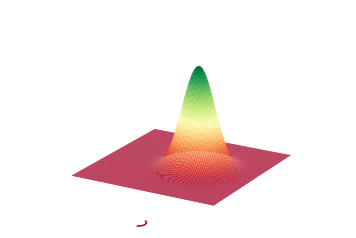

In [10]:
import numpy as np
cutoff = 10
l = 5
# Offset for contour plot of Wigner function
offset = -0.15
#wigner function for plotting
def wigner(rho, xvec, pvec): #wigner function is defined with arguments xvec and pvec 
    Q, P = np.meshgrid(xvec, pvec) #returns matrix instead of vector 
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2)) #makes QP a complex number 
    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)]) #creates an array of shape A and contains 0s and the complex number 
    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi 
    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0]) 
    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])
    for m in range(1, cutoff):
        temp = copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m)
                    * Wlist[m - 1]) / np.sqrt(m)
        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])
        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return W / 2
# Creates 2D grid for Wigner function plots
x = np.linspace(-5, 5, 100)
p = np.linspace(-5, 5, 100)
X, P = np.meshgrid(x, p)
# Density matrices of output and target states
stateket = state.ket()
dmstate = np.outer(stateket, np.conj(stateket)) #converts a pure state to a density matrix, you'll need to do this with your state 
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
Z = wigner(dmstate, x, p)
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, Z, 10, cmap="RdYlGn", linestyles="solid", offset=offset)
ax.set_axis_off()

We can make a couple of observations from the Gaussian distribution above. We can notice that it has positive quasi-probability distributions. Later on, we'll have a look at non-Gaussian gates that have negative quasi-probability distributions. The vacuum state is also centered at 0 on both the position axis $\hat {x}$ and momentum axis $\hat {p}$. 

## Squeezing Gate

The squeezing gate can also be thought of as a transformation on the position and momentum axes. The squeezing gate shifts $\hat{x}$ to $e^{ - r}\hat{x} _\phi$ and shifts $\hat{p}$ with $e^r$$\hat{p} _\phi$. In the wigner function, we can see the probability distribution being lengthened on the momentum axis and being pinched on the position axis. As the squeezing gate is a Gaussian gate, there are no negative quasi-probabilty distributions.  

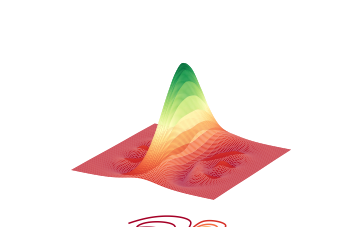

In [27]:
#eng, q = sf.Engine(1)
with eng:
    S = Sgate(1)
    S | q[0]  
state = eng.run('fock', cutoff_dim = 10)
stateket = state.ket()
dmstate = np.outer(stateket, np.conj(stateket)) #converts a pure state to a density matrix, you'll need to do this with your state 
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
Z = wigner(dmstate, x, p)
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, Z, 10, cmap="RdYlGn", linestyles="solid", offset=offset)
ax.set_axis_off()

In [64]:
from IPython.display import Image
Image(url="https://github.com/BriannaGopaul/strawberryfields/blob/master/doc/gallery/gifs/squeezinggif.gif?raw=true", width = 250, height = 250)

The above wigner function shows the squeezing gate acting on the vacuum state with increasing strengths of parameters. The below wigner function gifs will also show the transformation of the state as the parameters increase in value. 

## Rotation Gate

The rotation gate shifts the $\hat{x}$ quadrature to $\hat{x}$ $\cos \phi$ - $\hat{p}\sin$ $\phi$ and $\hat{p}$ to $\hat{p}$ $\cos \phi$ + $\hat{x}$$\sin$  $\phi$. In other words, the gate simply rotates the vacuum state. 

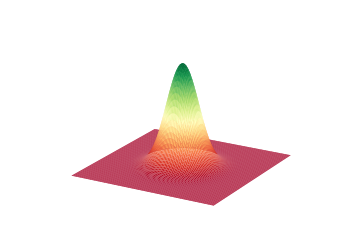

In [28]:
#eng, q = sf.Engine(1)
with eng: 
    Rgate(0.55) | q[0]
state_r = eng.run('fock', cutoff_dim = 10)
state_r = state_r.ket()
dmstate_r = np.outer(state_r, np.conj(state_r)) 
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
Z = wigner(dmstate_r, x, p)
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, Z, 10, cmap="RdYlGn", linestyles="solid", offset=offset)
ax.set_axis_off()

Above we apply the rotation gate to a squeezed state. When compared to the squeezed state in the previous example, the rotation gate simply makes a rotation. 

In [60]:
from IPython.display import Image
Image(url="https://github.com/BriannaGopaul/strawberryfields/blob/master/doc/gallery/gifs/ezgif.com-resize%20(4).gif?raw=true", width = 250, height = 250)

## Displacement Gate 

The displacement gate has a specified complex value $\alpha$. It shifts $\hat{x}$ by a value porportional to $Re(\alpha)$ and the $\hat {p}$ by a value $Im({\alpha})$. 

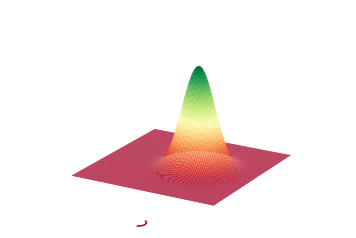

In [33]:
#eng, q = sf.Engine(1)
with eng:
    Dgate(0.55) | q[0]
state = eng.run('fock', cutoff_dim = 10)
stateket = state.ket()
dmstate = np.outer(stateket, np.conj(stateket)) #converts a pure state to a density matrix, you'll need to do this with your state 
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
Z = wigner(dmstate, x, p)
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, Z, 10, cmap="RdYlGn", linestyles="solid", offset=offset)
ax.set_axis_off()

In [61]:
from IPython.display import Image
Image(url="https://github.com/BriannaGopaul/strawberryfields/blob/master/doc/gallery/gifs/displacementgif.gif?raw=true", width = 250, height = 250)

As $\alpha$ increases in value, the state is displaced more to the right. 

## Cubic Phase Gate 

The cubic phase gate shifts $\hat{p}$ by $\gamma\hat{x}^2$ where $\gamma$ is a definable parameter but does not transform $\hat{x}$ in the phase space. Below, we decide to set $\gamma=2$.  

When running a circuit that contains any non-Gaussian gates, we use the fock backend. Depending on the backend used, different arguments will have to be called. In this example, we define 'cutoff_dim' which tells Strawberry Fields where to limit the fock space. 

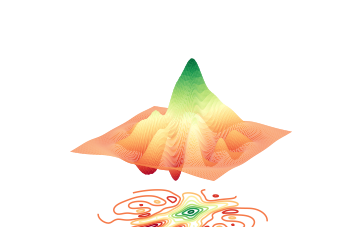

In [34]:
#eng, q = sf.Engine(1)
with eng:
    gamma = 2
    Vgate(gamma) | q[0]
#We use the fock backend and define the argument cutoff_dim
state = eng.run('fock', cutoff_dim=10)
stateket = state.ket()
dmstate = np.outer(stateket, np.conj(stateket)) 
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
Z = wigner(dmstate, x, p)
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, Z, 10, cmap="RdYlGn", linestyles="solid", offset=offset)
ax.set_axis_off()

Here we can see that the vacuum state has been shifted to a state where it reaches negative quasi-probability distributions

In [62]:
from IPython.display import Image
Image(url="https://github.com/BriannaGopaul/strawberryfields/blob/master/doc/gallery/gifs/cubicphasegif.gif?raw=true", width = 250, height = 250)

## Kerr Gate 

Before we understand how the Kerr gate operates, we should first take another look at the rotation gate. In the fock basis, the rotation gate acts with $e^{ i\phi \hat{n}}$. In comparison, the Kerr gates transforms with $e^{ i\phi k \hat{n}^2}$. The $^2$ value is what makes this state non-Gaussian and thus transforms the shape of the state significantly. 

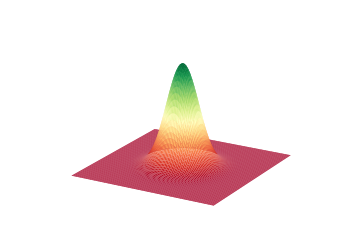

In [11]:
# eng, q = sf.Engine(1)
with eng:
    kappa = 0.5
    Kgate(kappa) | q[0]
state = eng.run('fock', cutoff_dim = 10)
stateket = state.ket()
dmstate = np.outer(stateket, np.conj(stateket)) #converts a pure state to a density matrix, you'll need to do this with your state 
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
Z = wigner(dmstate, x, p)
ax.plot_surface(X, P, Z, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, Z, 10, cmap="RdYlGn", linestyles="solid", offset=offset)
ax.set_axis_off()

In [63]:
from IPython.display import Image
Image(url="https://github.com/BriannaGopaul/strawberryfields/blob/master/doc/gallery/gifs/kerrgif.gif?raw=true", width = 250, height = 250)

In the above wigner function, the state is initially in a coherent state. We can see it's coherent structure morphing after the Kerr gate is applied at different strengths. 

For more information about CV gates, read: [Strawberry Fields: CV Gates Docs](https://strawberryfields.readthedocs.io/en/latest/conventions/gates.html)